# Cellxgene collections metadata

In this notebook I download and visualize metadata on all the human datasets in [CellxGene collections](https://cellxgene.cziscience.com/collections) using the [cellxgene_census API](https://chanzuckerberg.github.io/cellxgene-census/index.html).

The main outputs are:
- `/nfs/team205/ed6/data/cellxgene_hsapiens_cell_metadata.csv` - cell level metadata for all adult *H.Sapiens* datasets
- `/nfs/team205/ed6/bin/sc_target_evidence/data/cellxgene_hsapiens_donor_metadata.csv` - donor level metadata (used for dataset selection)

In [1]:
import cellxgene_census
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# help(cellxgene_census)
# help(cellxgene_census.get_anndata)

R plotting setup

In [2]:
## r2py setup
# import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# anndata2ri.activate()

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


## Open connection to cellxgene

In [5]:
census = cellxgene_census.open_soma()

The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.


## Get cell level metadata

Following tutorial https://chanzuckerberg.github.io/cellxgene-census/cellxgene_census_docsite_quick_start.html#python-quick-start 

See [here](https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/3.0.0/schema.md#obs-cell-metadata) for list of all the possible `obs` columns. 

In [6]:
cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
    column_names = ["assay", "tissue", "tissue_general", "suspension_type", "disease", 'dataset_id', 'is_primary_data', 'donor_id', 'development_stage_ontology_term_id',
                   'cell_type_ontology_term_id',
                    'cell_type'
                   ]
)

# Concatenates results to pyarrow.Table
cell_metadata = cell_metadata.concat()

# Converts to pandas.DataFrame
cell_metadata = cell_metadata.to_pandas()

In [7]:
cell_metadata.head()

,assay,tissue,tissue_general,suspension_type,disease,dataset_id,is_primary_data,donor_id,development_stage_ontology_term_id,cell_type_ontology_term_id,cell_type
0,10x 3' v3,decidua basalis,placenta,nucleus,normal,f171db61-e57e-4535-a06a-35d8b6ef8f2b,False,P13_fetus,HsapDv:0000046,CL:0000525,syncytiotrophoblast cell
1,10x 3' v3,decidua basalis,placenta,nucleus,normal,f171db61-e57e-4535-a06a-35d8b6ef8f2b,False,P13_fetus,HsapDv:0000046,CL:2000060,placental villous trophoblast
2,10x 3' v3,decidua basalis,placenta,nucleus,normal,f171db61-e57e-4535-a06a-35d8b6ef8f2b,False,P13_fetus,HsapDv:0000046,CL:0000525,syncytiotrophoblast cell
3,10x 3' v3,decidua basalis,placenta,nucleus,normal,f171db61-e57e-4535-a06a-35d8b6ef8f2b,False,P13_fetus,HsapDv:0000046,CL:0000525,syncytiotrophoblast cell
4,10x 3' v3,decidua basalis,placenta,nucleus,normal,f171db61-e57e-4535-a06a-35d8b6ef8f2b,False,P13_fetus,HsapDv:0000046,CL:0008036,extravillous trophoblast


## Get metadata on datasets

In [8]:
census_datasets = census["census_info"]["datasets"].read().concat().to_pandas()

# for convenience, indexing on the soma_joinid which links this to other census data.
census_datasets = census_datasets.set_index("soma_joinid")

In [9]:
census_datasets

,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
soma_joinid,,,,,,,
0,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,f171db61-e57e-4535-a06a-35d8b6ef8f2b,donor_p13_trophoblasts,f171db61-e57e-4535-a06a-35d8b6ef8f2b.h5ad,31497
1,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,ecf2e08e-2032-4a9e-b466-b65b395f4a02,All donors trophoblasts,ecf2e08e-2032-4a9e-b466-b65b395f4a02.h5ad,67070
2,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,74cff64f-9da9-4b2a-9b3b-8a04a1598040,All donors all cell states (in vivo),74cff64f-9da9-4b2a-9b3b-8a04a1598040.h5ad,286326
3,f7cecffa-00b4-4560-a29a-8ad626b8ee08,Mapping single-cell transcriptomes in the intr...,10.1016/j.ccell.2022.11.001,5af90777-6760-4003-9dba-8f945fec6fdf,Single-cell transcriptomic datasets of Renal c...,5af90777-6760-4003-9dba-8f945fec6fdf.h5ad,270855
4,3f50314f-bdc9-40c6-8e4a-b0901ebfbe4c,Single-cell sequencing links multiregional imm...,10.1016/j.ccell.2021.03.007,bd65a70f-b274-4133-b9dd-0d1431b6af34,Single-cell sequencing links multiregional imm...,bd65a70f-b274-4133-b9dd-0d1431b6af34.h5ad,167283
...,...,...,...,...,...,...,...
588,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7,f9ad5649-f372-43e1-a3a8-423383e5a8a2,Molecular characterization of selectively vuln...,f9ad5649-f372-43e1-a3a8-423383e5a8a2.h5ad,8168
589,a72afd53-ab92-4511-88da-252fb0e26b9a,Single-cell atlas of peripheral immune respons...,10.1038/s41591-020-0944-y,456e8b9b-f872-488b-871d-94534090a865,Single-cell atlas of peripheral immune respons...,456e8b9b-f872-488b-871d-94534090a865.h5ad,44721
590,38833785-fac5-48fd-944a-0f62a4c23ed1,Construction of a human cell landscape at sing...,10.1038/s41586-020-2157-4,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,Construction of a human cell landscape at sing...,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf.h5ad,598266


## Save cell-level metadata

In [10]:
## Exclude fetal data
min_dev_stage = 80 # HsapDv_0000081
stage_is_fetal = {x:int(x.split(":")[1]) < min_dev_stage for x in cell_metadata['development_stage_ontology_term_id'].unique() if x.startswith('Hsap')}
cell_metadata['is_fetal'] =[stage_is_fetal[x] if x != 'unknown' else False for x in cell_metadata['development_stage_ontology_term_id']]
cell_metadata = cell_metadata[~ cell_metadata['is_fetal']]

## Exclude data that has been re-analysed in different studies
cell_metadata = cell_metadata[cell_metadata.is_primary_data]

# Make sample identifier
cell_metadata['sample_id'] = cell_metadata['assay'] + cell_metadata.tissue_general + cell_metadata.donor_id
cell_metadata['sample_id'].nunique()

## Clean assay assignment
rename_assay = {
    'single cell library construction':'unknown',
    'single-cell RNA sequencing':'unknown',
    '10x technology':'unknown',
    "10x 3' transcription profiling":"10x 3' v1",
    "10x 5' transcription profiling":"10x 5' v1",
}
cell_metadata.replace({'assay':rename_assay}, inplace=True)

In [11]:
cell_metadata.to_csv('/nfs/team205/ed6/data/cellxgene_hsapiens_cell_metadata.csv')

## Reduce to donor-level metadata

In [29]:
donor_cols = ["assay", "tissue", "tissue_general", "suspension_type", "disease", 'dataset_id', 'is_primary_data', 'donor_id', 'development_stage_ontology_term_id']

cell_metadata.drop(['cell_type', 'cell_type_ontology_term_id'], axis=1, inplace=True)
donor_metadata = cell_metadata.drop_duplicates(donor_cols)

In [31]:
# Make sample identifier
donor_metadata['sample_id'] = donor_metadata['assay'] + donor_metadata.tissue_general + donor_metadata.donor_id
donor_metadata['sample_id'].nunique()

## Clean assay assignment
rename_assay = {
    'single cell library construction':'unknown',
    'single-cell RNA sequencing':'unknown',
    '10x technology':'unknown',
    "10x 3' transcription profiling":"10x 3' v1",
    "10x 5' transcription profiling":"10x 5' v1",
}
donor_metadata.replace({'assay':rename_assay}, inplace=True)

## Exclude fetal data

min_dev_stage = 80 # HsapDv_0000081
stage_is_fetal = {x:int(x.split(":")[1]) < min_dev_stage for x in donor_metadata['development_stage_ontology_term_id'].unique() if x.startswith('Hsap')}
donor_metadata['is_fetal'] =[stage_is_fetal[x] if x != 'unknown' else False for x in donor_metadata['development_stage_ontology_term_id']]
donor_metadata = donor_metadata[~ donor_metadata['is_fetal']]

## Exclude data that has been re-analysed in different studies
donor_metadata = donor_metadata[donor_metadata.is_primary_data]

In [22]:
donor_metadata

,assay,tissue,tissue_general,suspension_type,disease,dataset_id,is_primary_data,donor_id,development_stage_ontology_term_id,sample_id,is_fetal
0,10x 3' v3,subcutaneous abdominal adipose tissue,adipose tissue,nucleus,normal,9d8e5dca-03a3-457d-b7fb-844c75735c83,True,donor-GOLD,HsapDv:0000147,10x 3' v3adipose tissuedonor-GOLD,False
869,10x 3' v3,visceral abdominal adipose tissue,adipose tissue,nucleus,normal,9d8e5dca-03a3-457d-b7fb-844c75735c83,True,donor-BOAT,HsapDv:0000148,10x 3' v3adipose tissuedonor-BOAT,False
4369,10x 3' v3,subcutaneous abdominal adipose tissue,adipose tissue,nucleus,normal,9d8e5dca-03a3-457d-b7fb-844c75735c83,True,donor-KEYS,HsapDv:0000122,10x 3' v3adipose tissuedonor-KEYS,False
8675,10x 3' v3,visceral abdominal adipose tissue,adipose tissue,nucleus,normal,9d8e5dca-03a3-457d-b7fb-844c75735c83,True,donor-PINK,HsapDv:0000129,10x 3' v3adipose tissuedonor-PINK,False
10740,10x 3' v3,visceral abdominal adipose tissue,adipose tissue,nucleus,normal,9d8e5dca-03a3-457d-b7fb-844c75735c83,True,donor-APEX,HsapDv:0000131,10x 3' v3adipose tissuedonor-APEX,False
...,...,...,...,...,...,...,...,...,...,...,...
53729066,10x 3' v2,lung,lung,cell,normal,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,True,2,HsapDv:0000140,10x 3' v2lung2,False
53757859,10x 3' v2,blood,blood,cell,normal,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,True,1,HsapDv:0000169,10x 3' v2blood1,False
53758183,10x 3' v2,lung,lung,cell,normal,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,True,1,HsapDv:0000169,10x 3' v2lung1,False
53767603,10x 3' v2,lung,lung,cell,normal,8c42cfd0-0b0a-46d5-910c-fc833d83c45e,True,3,HsapDv:0000145,10x 3' v2lung3,False


In [23]:
donor_metadata.to_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_metadata.csv')
donor_metadata.to_csv('/nfs/team205/ed6/bin/sc_target_evidence/data/cellxgene_hsapiens_donor_metadata.csv')

### Count donors by tissue

In [24]:
donors_by_tissue = donor_metadata[['donor_id', 'disease', 'tissue_general', 'suspension_type']].drop_duplicates()
donors_by_tissue = donors_by_tissue.groupby(['disease', 'tissue_general']).size().reset_index()
donors_by_tissue.columns = ['disease', 'tissue_general', 'n_donors']

In [27]:
donors_by_tissue.to_csv('/home/jovyan/mount/gdrive/sc_targetID/data/cellxgene_hsapiens_donor_by_tissue.csv')

In [25]:
donors_by_tissue.sort_values('n_donors', ascending=False)

,disease,tissue_general,n_donors
84,normal,blood,1783
3,COVID-19,blood,509
44,glioblastoma,brain,229
103,normal,lung,186
54,lung adenocarcinoma,lung,162
...,...,...,...
11,Down syndrome,bone marrow,1
12,Wilms tumor,kidney,1
119,normal,spinal cord,1
18,adenocarcinoma,small intestine,1


In [26]:
donors_by_tissue = donors_by_tissue.pivot(index='disease', columns='tissue_general', values='n_donors').fillna(0)
donors_by_tissue[donors_by_tissue < 3] = 0 # Keep if at least 3 donors

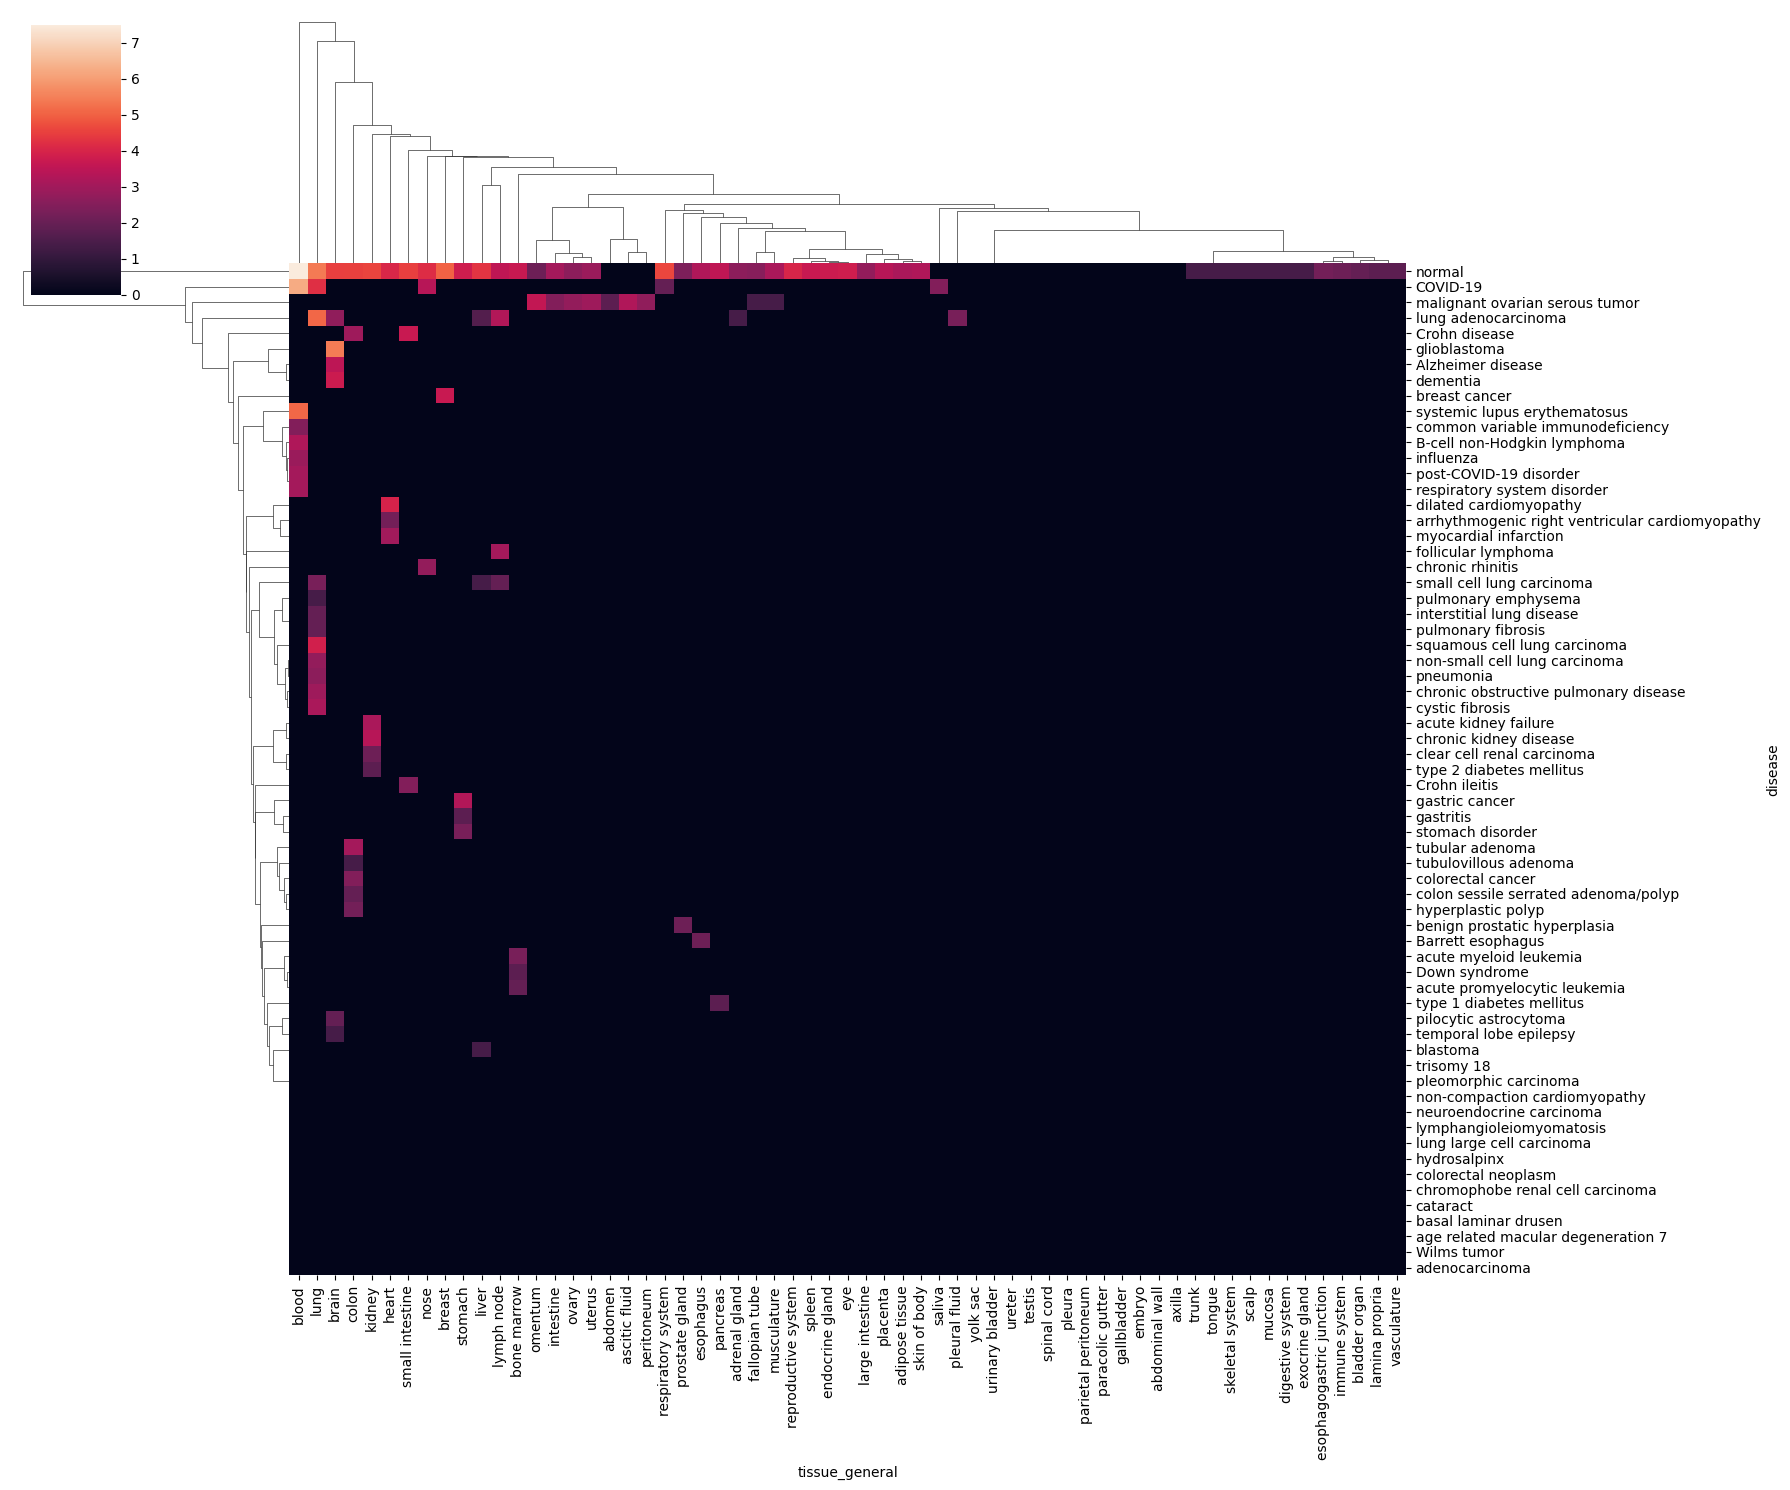

In [76]:
sns.clustermap(np.log1p(donors_by_tissue), figsize=(18,15), xticklabels=True, yticklabels=True)

----

## Visualizations

In [511]:
%%R -i donor_metadata
head(donor_metadata)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                      collection_name                        collection_id
0 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
1 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
2 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
3 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
4 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
5 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
      assay tissue tissue_general suspension_type disease    donor_id
0 10x 5' v2  blood          blood            cell  normal SG_HEL_H02a
1 10x 5' v2  blood          blood            cell  normal SG_HEL_H09a
2 10x 5' v2  blood          blood            cell  normal SG_HEL_H10a
3 10x 5' v2  blood          blood            cell  normal SG_HEL_H11a
4 10x 5' v2  blood          blood            cell  normal SG_HEL_H12a
5 10x 5' v2  blood          blood            cell  norm

`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.


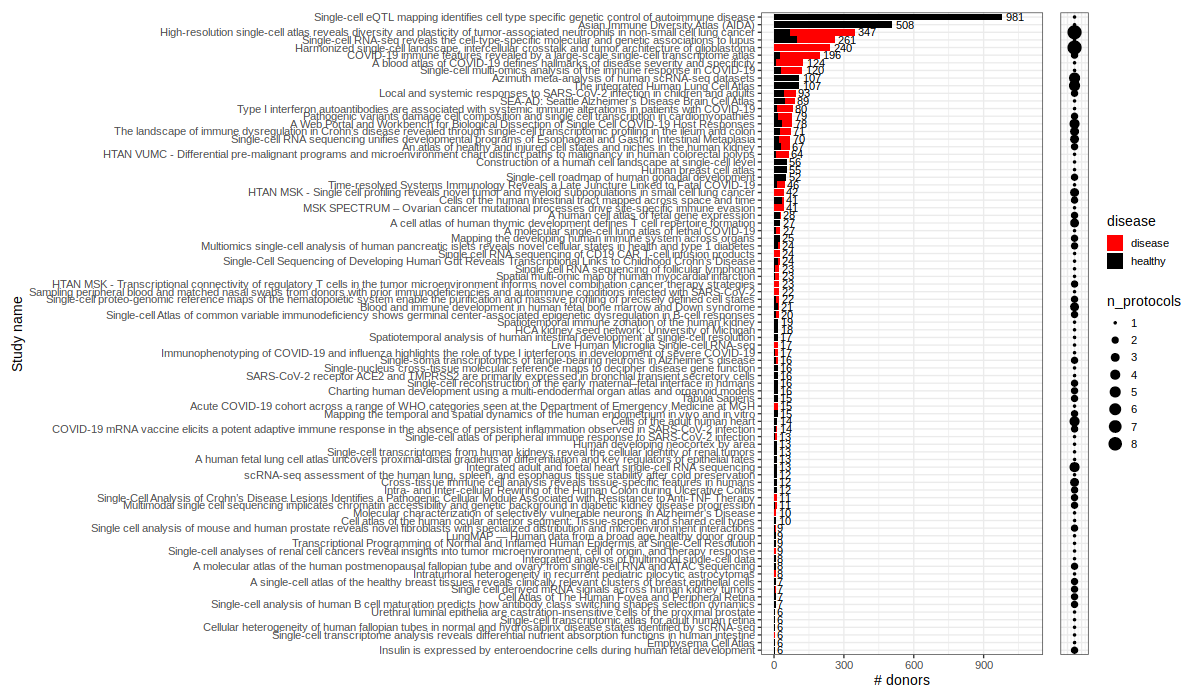

In [512]:
%%R -w 1200 -h 700
pl_df <- donor_metadata %>%
    mutate(protocol = str_c(suspension_type, '_',assay)) %>%
    mutate(sample_id = str_c(protocol, '_', donor_id, '_', tissue)) %>%
    group_by(collection_id, collection_name) %>%
    mutate(
        n_donors = length(unique(donor_id)),
        n_samples = length(unique(sample_id)), 
        n_protocols=length(unique(protocol))) %>%
    ungroup() %>%
    arrange(n_donors) %>%
    mutate(collection_name = factor(collection_name, levels=unique(collection_name))) %>%
    filter(n_donors > 5) 

pl_donors <- pl_df %>%
    distinct(collection_name, donor_id, disease) %>%
    group_by(collection_name, donor_id) %>%
    summarise(n_disease_samples = sum(disease != 'normal')) %>%
    mutate(disease = ifelse(n_disease_samples > 0, 'disease', 'healthy')) %>%
    group_by(collection_name, disease) %>%
    summarise(n_donors = n()) %>%
    ggplot(aes(collection_name, n_donors)) +
    geom_col(aes(fill=disease)) +
    geom_text(data = . %>% group_by(collection_name) %>% summarise(n_donors=sum(n_donors)),
              aes(label = paste0(n_donors)), color='black', hjust=-0.2) +
    coord_flip() +
    scale_fill_manual(values=c(healthy='black', disease='red')) +
    ylim(0,1100) +
    xlab('Study name') +
    ylab('# donors') +
    theme_bw(base_size=14)

protocols_df <- pl_df %>%
    distinct(collection_name, n_protocols) %>%
    ggplot(aes(collection_name, y=1, size= n_protocols)) +
    geom_point() +
    coord_flip() +
    scale_size(breaks=seq(0,8)) +
    theme_bw(base_size=14) +
    remove_y_axis() + remove_x_axis() 
    
(pl_donors + protocols_df) +
plot_layout(widths=c(10,1), guides='collect')
# scale_fill_brewer(palette='Spectral')
# theme(axis.text.x=element_text(angle=90))

`summarise()` has grouped output by 'collection_id'. You can override using the
`.groups` argument.


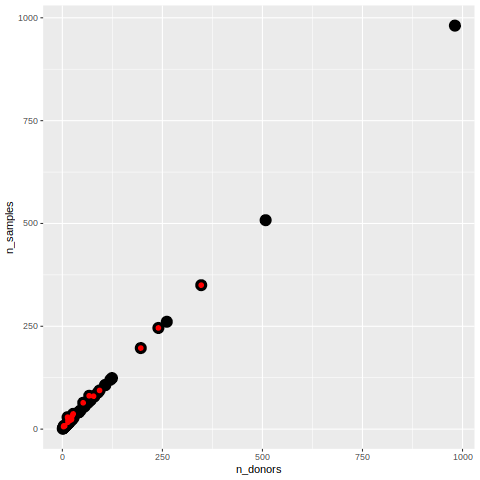

In [513]:
%%R
donor_metadata %>%
mutate(protocol = str_c(suspension_type, '_',assay)) %>%
mutate(sample_id = str_c(protocol, '_', donor_id)) %>%
group_by(collection_id, collection_name) %>%
summarise(
    n_donors = length(unique(donor_id)),
    n_samples = length(unique(sample_id)), 
    n_protocols=length(unique(protocol))) %>%
ungroup() %>%
arrange(n_samples) %>%
mutate(collection_label = ifelse(n_samples > n_donors, collection_name, NA)) %>%
mutate(collection_name = factor(collection_name, levels=unique(collection_name))) %>%
ggplot(aes(n_donors, n_samples)) +
geom_point(size=5) +
# scale_y_log10() + scale_x_log10() +
geom_point(data=. %>% filter(!is.na(collection_label)), color='red', size=2)


### Healthy atlases

In [514]:
n_tissues = donor_metadata[['collection_id', 'tissue_general']].drop_duplicates().groupby('collection_id').size()
crosstissue_ids = n_tissues[n_tissues > 5].index

donor_metadata['tissue_short'] = np.where(donor_metadata['collection_id'].isin(crosstissue_ids), 'cross-tissue', donor_metadata['tissue_general']) 

In [515]:
rename_tissue = {
    'small intestine':'digestive system',
    'large intestine':'digestive system',
    'gallbladder':'digestive system',
    'tongue':'digestive system',
    'colon':'digestive system',
    'lamina propria':'digestive system',
    'esophagus':'digestive system',
    'stomach':'digestive system',
    'lung':'respiratory system',
    'trachea':'respiratory system',
    'nose':'respiratory system',
    'ovary':'reproductive system',
    'uterus':'reproductive system',
    'fallopian tube':'reproductive system'
}

donor_metadata.replace({'tissue_short':rename_tissue}, inplace=True)

In [516]:
%%R -i donor_metadata
head(donor_metadata)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                      collection_name                        collection_id
0 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
1 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
2 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
3 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
4 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
5 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
      assay tissue tissue_general suspension_type disease    donor_id
0 10x 5' v2  blood          blood            cell  normal SG_HEL_H02a
1 10x 5' v2  blood          blood            cell  normal SG_HEL_H09a
2 10x 5' v2  blood          blood            cell  normal SG_HEL_H10a
3 10x 5' v2  blood          blood            cell  normal SG_HEL_H11a
4 10x 5' v2  blood          blood            cell  normal SG_HEL_H12a
5 10x 5' v2  blood          blood            cell  norm

In [517]:
%%R -w 1200 -h 1000
pl_df <- donor_metadata %>%
    mutate(protocol = str_c(suspension_type, '_',assay)) %>%
    mutate(sample_id = str_c(protocol, '_', donor_id, '_', tissue)) %>%
    group_by(collection_id, collection_name) %>%
    mutate(
        n_donors = length(unique(donor_id)),
        n_samples = length(unique(sample_id)), 
        n_protocols=length(unique(protocol))) %>%
    ungroup() %>%
    arrange(n_donors) %>%
    mutate(collection_name = factor(collection_name, levels=unique(collection_name))) %>%
    filter(n_donors > 10) 

`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'collection_name', 'tissue_short'. You can
override using the `.groups` argument.
Joining with `by = join_by(collection_name)`
`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.


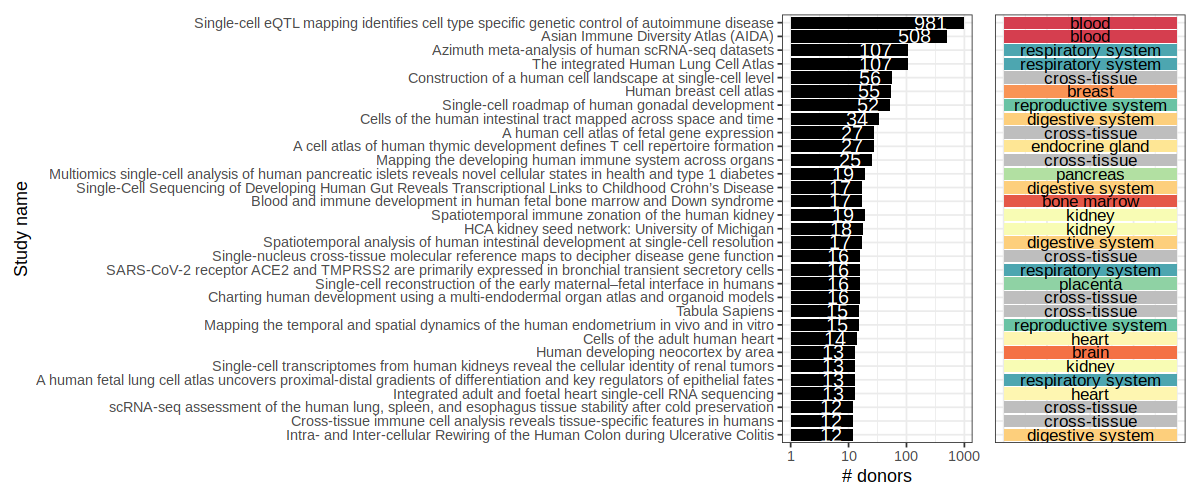

In [518]:
%%R -w 1200 -h 500 -o keep_studies
library(RColorBrewer)

## Filter healthy only
keep_studies <- pl_df %>%
    distinct(collection_name, donor_id, disease) %>%
    group_by(collection_name, donor_id) %>%
    summarise(n_disease_samples = sum(disease != 'normal')) %>%
    mutate(disease = ifelse(n_disease_samples > 0, 'disease', 'healthy')) %>%
    group_by(collection_name) %>%
    summarise(n_normal = sum(disease == 'healthy'), n_all=n()) %>%
    filter(n_normal/n_all > 0.7) %>%
    pull(collection_name)

# Make palette for tissues
getPalette = colorRampPalette(brewer.pal(9, "Spectral"))
all_tissues <- filter(pl_df, collection_name %in% keep_studies) %>% arrange(tissue_short) %>% pull(tissue_short) %>% unique()  
tissue_palette = setNames(getPalette(length(all_tissues)), all_tissues)
tissue_palette['cross-tissue'] = 'grey'

# Plot top study tissue (cross-tissue if many tissues are equally represented)
study_top_tissue <- pl_df %>%
    filter(collection_name %in% keep_studies) %>%
    distinct(collection_name, sample_id, tissue_short) %>%
    group_by(collection_name) %>%
    mutate(n_all=n() ) %>%
    ungroup() %>%
    group_by(collection_name, tissue_short, n_all) %>%
    summarise(tissue_freq = n()) %>%
    mutate(tissue_freq = tissue_freq/n_all) %>%
    ungroup() %>%
    group_by(collection_name) %>%
    top_n(1, tissue_freq) %>%
    mutate(tissue_short = ifelse(tissue_freq < 0.5, 'cross-tissue', tissue_short)) %>%
    rename(label_tissue = tissue_short) %>%
    select(collection_name, label_tissue) %>%
    ungroup()

pl_tissue <- left_join(pl_df, study_top_tissue) %>%
    filter(collection_name %in% keep_studies) %>%
    distinct(collection_name, label_tissue) %>%
    ggplot(aes(collection_name, fill=label_tissue)) +
    geom_bar(position='fill') +
    geom_text(aes(label=label_tissue, y=0.5), size=6) +
    scale_fill_manual(values=tissue_palette) +
    coord_flip() +
    xlab('Study name') +
    ylab('# donors') +
    theme_bw(base_size=18) +
    guides(fill='none') +
    remove_y_axis() + remove_x_axis()
    
# Plot number of donors in healthy atlases
pl_donors <- pl_df %>%
    filter(collection_name %in% keep_studies) %>%
    distinct(collection_name, donor_id, disease) %>%
    filter(disease == 'normal') %>%
    group_by(collection_name, disease) %>%
    summarise(n_donors = n()) %>%
    ggplot(aes(collection_name, n_donors)) +
    geom_col(fill='black') +
    geom_text(data = . %>% group_by(collection_name) %>% summarise(n_donors=sum(n_donors)),
              aes(label = paste0(n_donors)), color='white', hjust=1.5, size=7) +
    coord_flip() +
    ylim(0,1100) +
    xlab('Study name') +
    ylab('# donors') +
    scale_y_log10() +
    theme_bw(base_size=18)
    
(pl_donors + pl_tissue) +
plot_layout(widths=c(10,10))

In [560]:
%%R -o healthy_atlas_df
healthy_atlas_df <- left_join(pl_df, study_top_tissue) %>%
    filter(collection_name %in% keep_studies)

Joining with `by = join_by(collection_name)`


In [561]:
healthy_atlas_df = healthy_atlas_df[['collection_id', 'label_tissue', 'n_donors']].drop_duplicates()

In [562]:
studies_df = census_datasets[['collection_id', 'collection_name', 'collection_doi']].drop_duplicates()
studies_df

,collection_id,collection_name,collection_doi
soma_joinid,,,
0,ced320a1-29f3-47c1-a735-513c7084d508,Asian Immune Diversity Atlas (AIDA),
1,efd94500-1fdc-4e28-9e9f-a309d0154e21,HTAN MSK - Transcriptional connectivity of reg...,
2,1df8c90d-d299-4b2e-a54d-a5a80f36e780,Single-cell analyses of renal cell cancers rev...,10.1073/pnas.2103240118
5,48259aa8-f168-4bf5-b797-af8e88da6637,Human breast cell atlas,10.1101/2023.04.21.537845
9,1ca90a2d-2943-483d-b678-b809bf464c30,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,
...,...,...,...
529,367d95c0-0eb0-4dae-8276-9407239421ee,Evolution of cellular diversity in primary mot...,10.1038/s41586-021-03465-8
533,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7
545,a72afd53-ab92-4511-88da-252fb0e26b9a,Single-cell atlas of peripheral immune respons...,10.1038/s41591-020-0944-y


In [563]:
healthy_atlas_df = pd.merge(healthy_atlas_df, studies_df, how='left')
healthy_atlas_df = healthy_atlas_df[healthy_atlas_df.collection_doi!='']

In [564]:
# healthy_atlas_df = healthy_atlas_df[healthy_atlas_df['label_tissue'] != 'cross-tissue']
# healthy_atlas_df.sort_values('n_donors', ascending=False)

In [565]:
healthy_atlas_df[healthy_atlas_df['label_tissue'] == 'cross-tissue'].sort_values('n_donors', ascending=False)

,collection_id,label_tissue,n_donors,collection_name,collection_doi
26,38833785-fac5-48fd-944a-0f62a4c23ed1,cross-tissue,56,Construction of a human cell landscape at sing...,10.1038/s41586-020-2157-4
22,c114c20f-1ef4-49a5-9c2e-d965787fb90c,cross-tissue,28,A human cell atlas of fetal gene expression,10.1126/science.aba7721
20,b1a879f6-5638-48d3-8f64-f6592c1b1561,cross-tissue,25,Mapping the developing human immune system acr...,10.1126/science.abo0510
10,dfc09a93-bce0-4c77-893d-e153d1b7f9fa,cross-tissue,16,Charting human development using a multi-endod...,10.1016/j.cell.2021.04.028
13,a3ffde6c-7ad2-498a-903c-d58e732f7470,cross-tissue,16,Single-nucleus cross-tissue molecular referenc...,10.1126/science.abl4290
9,e5f58829-1a66-40b5-a624-9046778e74f5,cross-tissue,15,Tabula Sapiens,10.1126/science.abl4896
1,62ef75e4-cbea-454e-a0ce-998ec40223d3,cross-tissue,12,Cross-tissue immune cell analysis reveals tiss...,10.1126/science.abl5197
2,4d74781b-8186-4c9a-b659-ff4dc4601d91,cross-tissue,12,"scRNA-seq assessment of the human lung, spleen...",10.1186/s13059-019-1906-x


In [455]:
%%R -i donors_by_tissue
head(donors_by_tissue)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


     donor_id disease tissue_general tissue_short suspension_type
0 SG_HEL_H02a healthy          blood        blood            cell
1 SG_HEL_H09a healthy          blood        blood            cell
2 SG_HEL_H10a healthy          blood        blood            cell
3 SG_HEL_H11a healthy          blood        blood            cell
4 SG_HEL_H12a healthy          blood        blood            cell
5 SG_HEL_H13a healthy          blood        blood            cell


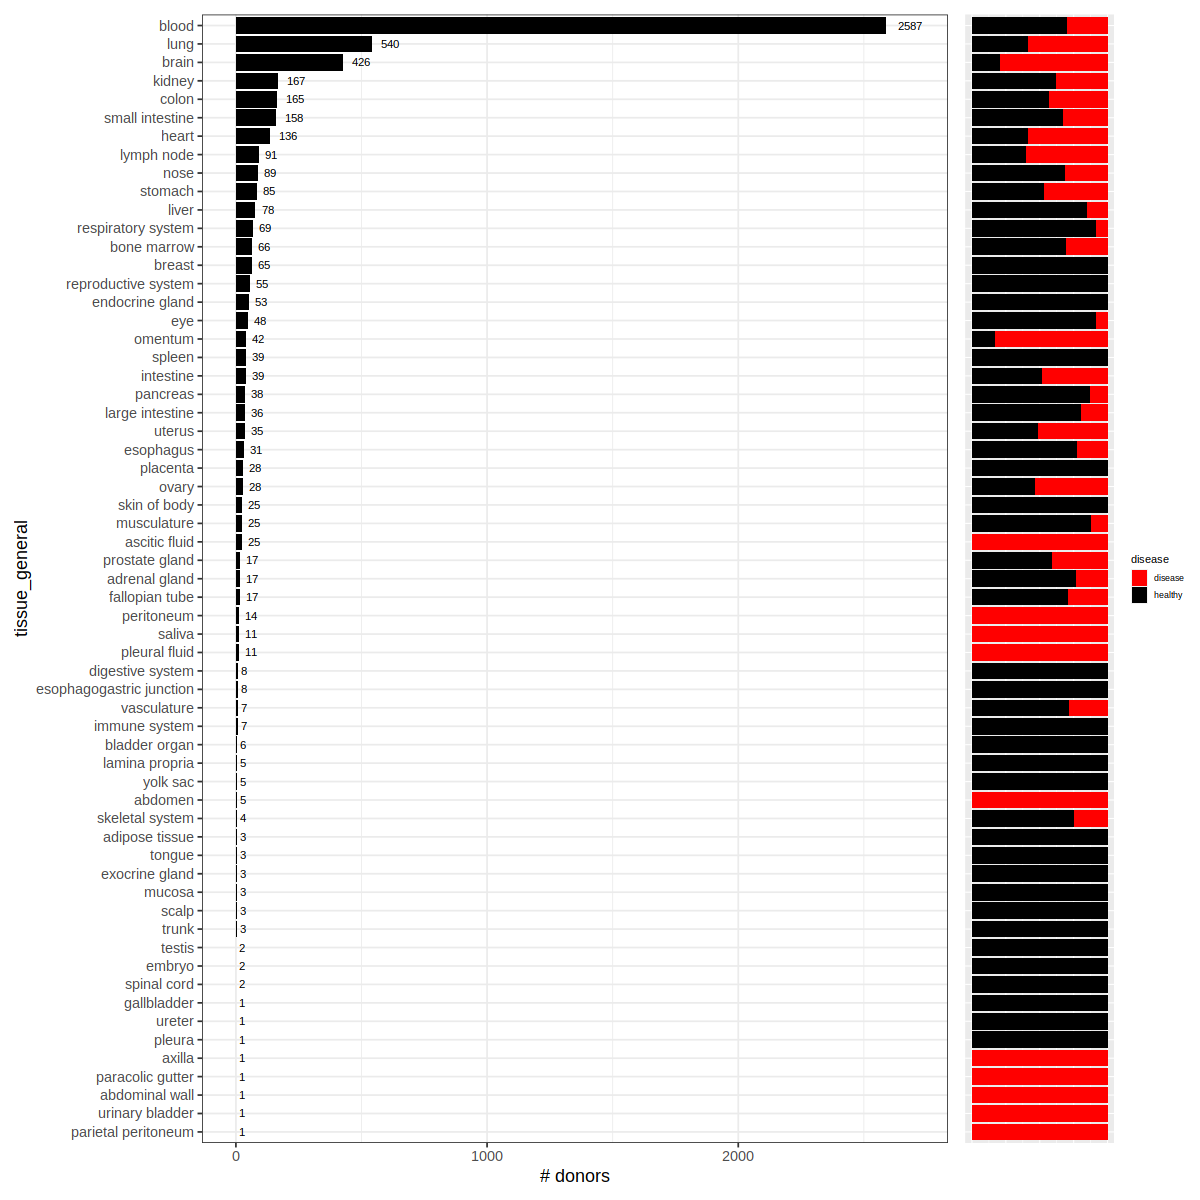

In [472]:
%%R -h 1200 -w 1200
pl_df <- donors_by_tissue %>%
    group_by(tissue_general) %>%
    mutate(n=n()) %>%
    ungroup() %>%
    arrange(n) %>%
    mutate(tissue_general = factor(tissue_general, levels=unique(tissue_general)))

tissue_donors_barplot <- pl_df %>%
    group_by(tissue_general) %>% summarise(n_donors=n()) %>%
    ggplot(aes(tissue_general, n_donors)) +
    geom_col(fill='black') +
    geom_text(
              aes(label = paste0(n_donors), ), color='black', hjust=-0.5, size=4) +
    coord_flip() +
    ylab('# donors') +
    ylim(0,2700) +
    theme_bw(base_size=18)
    
frac_disease_pl <- pl_df %>%
    ggplot(aes(tissue_general, fill=disease)) +
    geom_bar(position='fill') +
    coord_flip() +
    ylab('fraction') +
    scale_fill_manual(values=c(healthy='black', disease='red'))  +
    remove_y_axis() + remove_x_axis()
    
tissue_donors_barplot + frac_disease_pl +
plot_layout(widths=c(5,1))

### How many disease studies have matched controls?

In [567]:
donor_cols = ["assay", "tissue", "tissue_general", 
              "suspension_type", "disease", 'dataset_id', 'is_primary_data', 'donor_id']
donor_metadata = cell_metadata.drop_duplicates(donor_cols)
donor_metadata = pd.merge(census_datasets, donor_metadata, on='dataset_id')

In [568]:
donor_metadata = donor_metadata[donor_metadata.is_primary_data]


In [569]:
## Reduce to collections (datasets are compartments)
donor_cols = ["assay", "tissue", "tissue_general", 
              "suspension_type", "disease", 'donor_id']
donor_metadata = donor_metadata[['collection_name','collection_id'] + donor_cols].drop_duplicates()

In [570]:
%%R -i donor_metadata
head(donor_metadata)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


                      collection_name                        collection_id
0 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
1 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
2 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
3 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
4 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
5 Asian Immune Diversity Atlas (AIDA) ced320a1-29f3-47c1-a735-513c7084d508
      assay tissue tissue_general suspension_type disease    donor_id
0 10x 5' v2  blood          blood            cell  normal SG_HEL_H02a
1 10x 5' v2  blood          blood            cell  normal SG_HEL_H09a
2 10x 5' v2  blood          blood            cell  normal SG_HEL_H10a
3 10x 5' v2  blood          blood            cell  normal SG_HEL_H11a
4 10x 5' v2  blood          blood            cell  normal SG_HEL_H12a
5 10x 5' v2  blood          blood            cell  norm

`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'collection_name'. You can override using
the `.groups` argument.


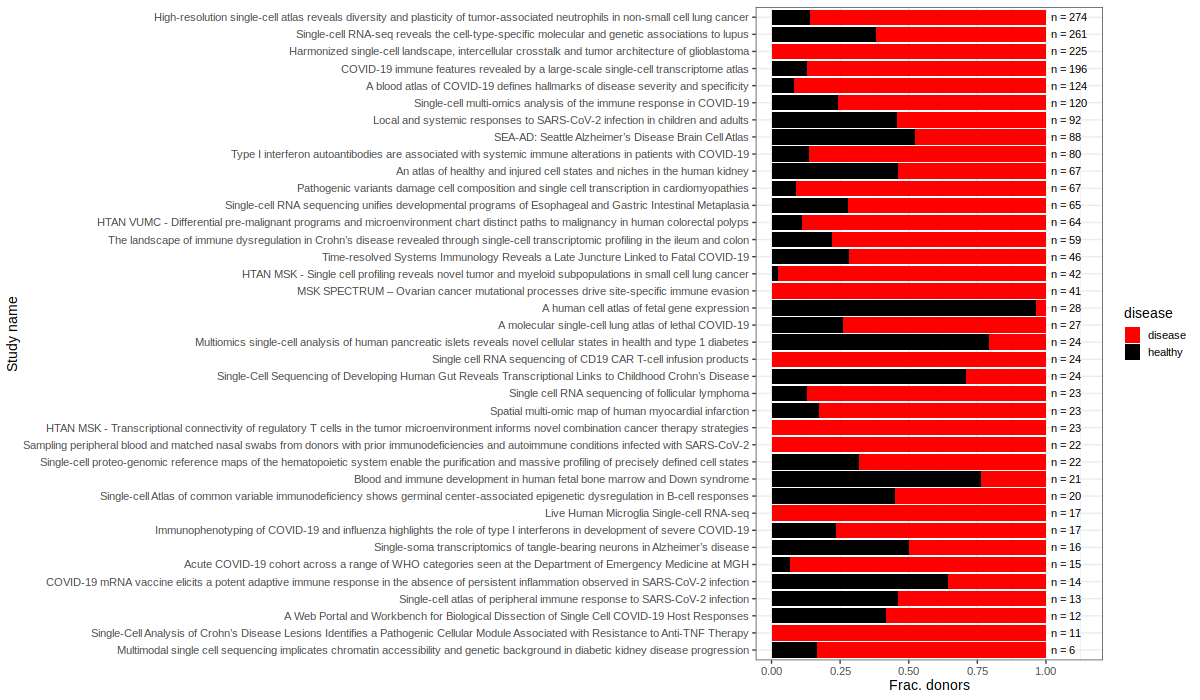

In [572]:
%%R -w 1200 -h 700 -o pl_df
## Filter studies with disease samples
keep_studies <- pl_df %>%
    distinct(collection_name, donor_id, disease) %>%
    group_by(collection_name, donor_id) %>%
    summarise(n_disease_samples = sum(disease != 'normal')) %>%
    mutate(disease = ifelse(n_disease_samples > 0, 'disease', 'healthy')) %>%
    group_by(collection_name) %>%
    summarise(n_normal = sum(disease == 'healthy'), n_all=n()) %>%
    filter(n_normal < n_all) %>%
    pull(collection_name)

pl_df <- donor_metadata %>%
    mutate(protocol = str_c(suspension_type, '_',assay)) %>%
    mutate(sample_id = str_c(protocol, '_', donor_id, '_', tissue)) %>%
    group_by(collection_id, collection_name) %>%
    mutate(
        n_donors = length(unique(donor_id)),
        n_samples = length(unique(sample_id)), 
        n_protocols=length(unique(protocol))) %>%
    ungroup() %>%
    arrange(n_donors) %>%
    mutate(collection_name = factor(collection_name, levels=unique(collection_name))) %>%
    filter(collection_name %in% keep_studies)

pl_donors <- pl_df %>%
    distinct(collection_name, donor_id, disease) %>%
    group_by(collection_name, donor_id) %>%
    summarise(n_disease_samples = sum(disease != 'normal')) %>%
    mutate(disease = ifelse(n_disease_samples > 0, 'disease', 'healthy')) %>%
    group_by(collection_name, disease) %>%
    summarise(n_donors = n()) %>%
    ungroup() %>%
    ggplot(aes(collection_name, n_donors)) +
    geom_col(aes(fill=disease), position='fill') +
    geom_text(data = . %>% group_by(collection_name) %>% summarise(n_donors=sum(n_donors)),
              aes(label = paste0("n = ", n_donors), y=1.02), color='black', hjust=0) +
    coord_flip() +
    scale_fill_manual(values=c(healthy='black', disease='red')) +
    expand_limits(y=1.15) +
    scale_y_continuous(breaks=seq(0,1, 0.25)) +
    xlab('Study name') +
    ylab('Frac. donors') +
    theme_bw(base_size=14)

    
pl_donors 
# scale_fill_brewer(palette='Spectral')
# theme(axis.text.x=element_text(angle=90))

In [582]:
pl_df[['disease', 'collection_id']]

disease
normal                                             31
COVID-19                                           13
lung adenocarcinoma                                 3
Alzheimer disease                                   2
respiratory system disorder                         2
influenza                                           2
Crohn disease                                       2
tubular adenoma                                     1
trisomy 18                                          1
temporal lobe epilepsy                              1
systemic lupus erythematosus                        1
stomach disorder                                    1
hyperplastic polyp                                  1
small cell lung carcinoma                           1
tubulovillous adenoma                               1
post-COVID-19 disorder                              1
non-small cell lung carcinoma                       1
non-compaction cardiomyopathy                       1
myocardial infarctio